# Fact checking Healthcare Claims

# Introduction

Fact-checking is the task of verifying the veracity of claims by assessing their assertions
against credible evidence. 

Generally in the past, fact checking was moslty limited to political claims and barely any research happened in any other field. 

This notebook aims to create a baseline standard for fact-checking in the scientific field. 
As of this moment, there already exist commendable frameworks for creating a fact-checking framework, and the same will be employed within this notebook using Pytorch. 

Resources considered: 
- [Bert for evidence Retrieval and Claim Verification](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7148011/)
- [Language models as fact-checkers](https://research.fb.com/wp-content/uploads/2020/07/Language-Models-as-Fact-Checkers.pdf)
- [SciBert](https://github.com/allenai/scibert)
- [Explainable Automated Fact Checking for Public Health Claims](https://arxiv.org/pdf/2010.09926.pdf)



## The Business Scenario

**Sorcero** has been focusing on creating language intelligence technologies to make advancements in the scientific field. This has helped them to create models and attain progress in the specific field. 

This entire notebook creates a demo model which showcases how a model can be used on the Health fact checking dataset. This can help out the industries that have been using Sorcero's tools to speed up the process. 

Keeping that in mind, I have gone forward to create a notebook which keeps that particular need in mind with each line of code. 

# Importing Libraries and Data

In [1]:
#Basic libraries:
import numpy as np
from tqdm.notebook import tqdm


#Data Loading library: 
import datasets

#Visualization
from visualization_functions import *
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import matplotlib.colors as mcolors
import plotly.express as px
alt.renderers.enable('default')
#Data Processing
from process_data import *
import random
import os
import math, time
import gc
gc.enable()


#metrics
from sklearn.metrics import classification_report, accuracy_score, f1_score


#suppress warnings; Done while refactoring notebook. 
import warnings
warnings.filterwarnings('ignore')


#model-utils
from model_utils import *


tqdm.pandas()

In [2]:
# Loading data
loaded_data = datasets.load_dataset('health_fact')
train_df, test_df, val_df = create_dataframe(loaded_data)

Using custom data configuration default
Reusing dataset health_fact (/home/shivam/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19)


## Overview of Data

In [3]:
train_df.head(1)

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,"


### Understanding what the columns mean

- This was performed after viewing the data in the huggingface data viewer and going through the github page of the data. 

**Columns**

- **claim_id**: The ID of that particular claim. 
- **claim**: The claim that is being made. This will be verified against the main_text to figure out whether it is true or unfounded. 
- **date_published**: The date when the article was published. 
- **explanation**: The justification for why a claim has been tagged as the way it is. 
- **fact_checkers**: The people who have performed the fact_checking. 
- **main_text**: The main_text, cleaned and preprocessed from all the article texts. 
- **sources**: The source from where the article was sourced. 
- **label**: The label ranging from -1 to 3, with each having it's particular value. This is what we are going to classify. (More on this later on in this notebook)
- **subjects**: The basic subject of the paritcular claim. 

I have always been taught that EDA is the art of asking questions to the dataset and figuring out information from it. So, let's get down to it. 

#### What are the different types of labels present in the dataset? 

In [4]:
train_df = eda_preprocess_dataframe(train_df)
test_df = eda_preprocess_dataframe(test_df)
val_df = eda_preprocess_dataframe(val_df)

In [5]:
# Dropping null values (aka, labels which were -1)

train_df = train_df[train_df['labels_text'].notna()].reset_index()
test_df = test_df[test_df['labels_text'].notna()].reset_index()
val_df = val_df[val_df['labels_text'].notna()].reset_index()

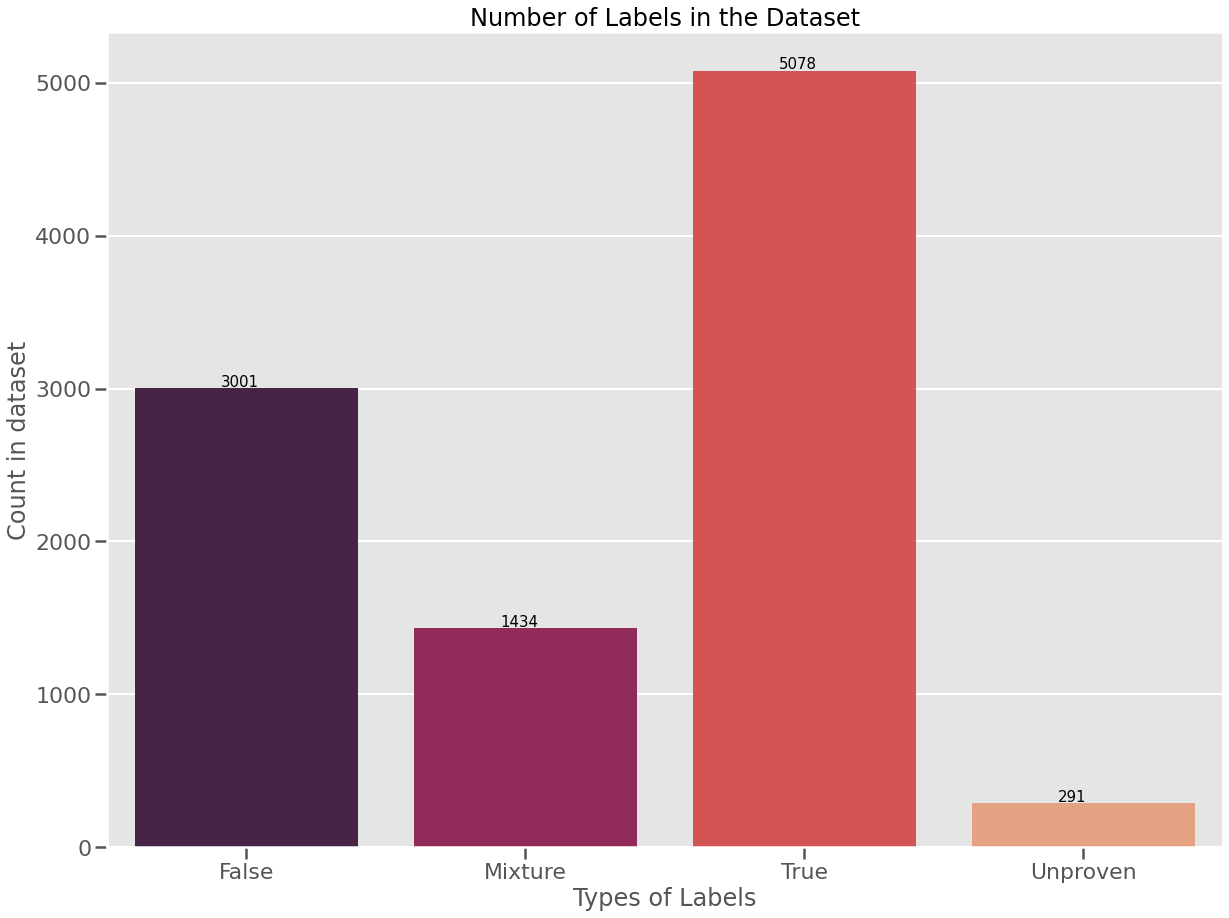

In [6]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
ax = sns.countplot(x='labels_text', data=train_df,  palette='rocket')
#Naming
plt.title("Number of Labels in the Dataset")
plt.xlabel("Types of Labels")
plt.ylabel("Count in dataset")
for i in ax.patches:
    ax.text(i.get_x()+.31, i.get_height()+10, str(round(i.get_height())), fontsize = 15, color = 'k')



Here we can observe: 
- There is a class imblance, that will be taken into account while building out the model during the loss function

To calculate the class weights:

In [7]:
class_weights = get_class_weight(train_df['label'])

#### What are the most prevelant subjects amongst all the entries? 

In [8]:
train_df.subjects = train_df.subjects.apply(lambda x: x.replace(',', ''))
wordcloud_create(train_df, "subjects")



From the wordcloud we can observe that most of the subjects are related to Health and wellbeing. 

#### How is the spread of entries throughout our database? 

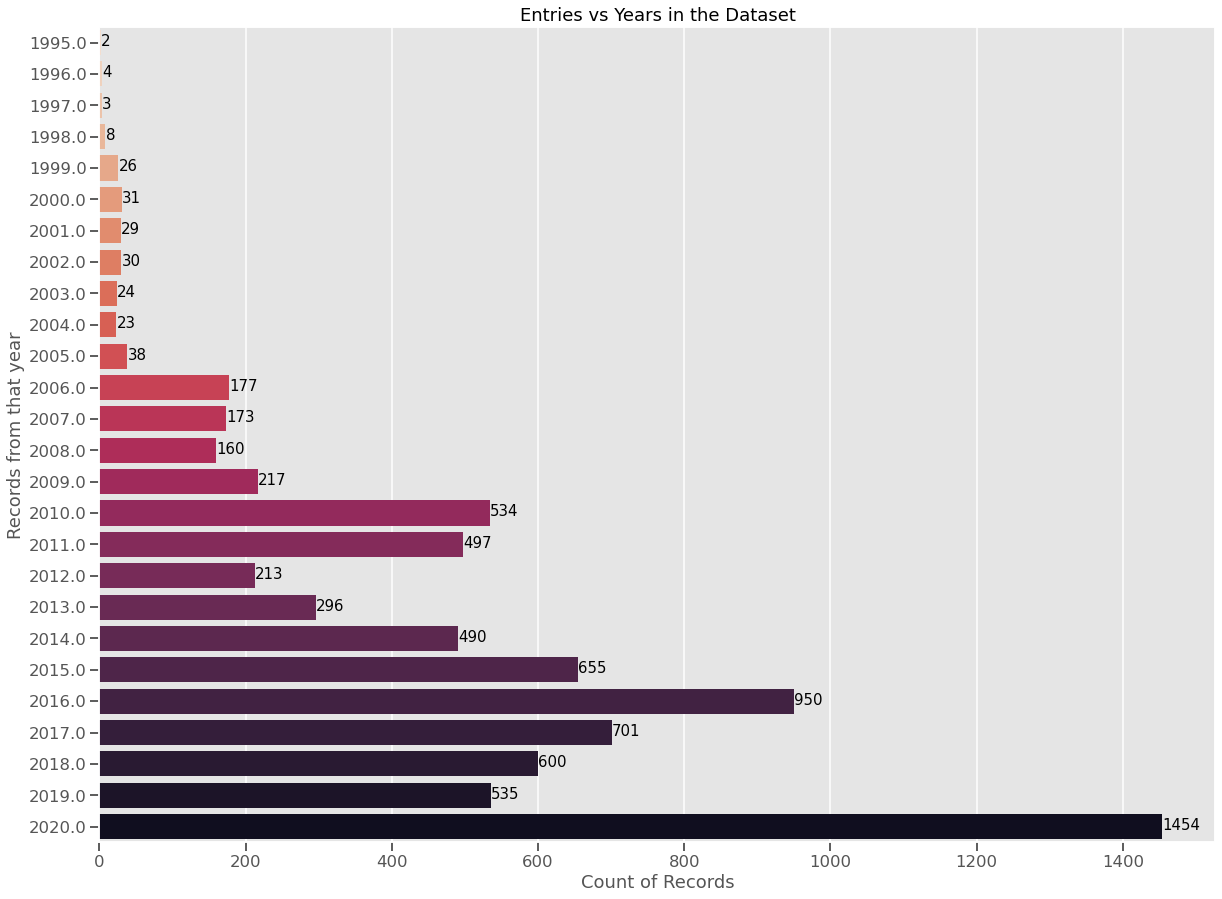

In [9]:
sns.set_context('talk')
plt.figure(figsize=(20,15))
ax = sns.countplot(y='date_published_year', data=train_df,  palette='rocket_r')
#Naming
plt.title("Entries vs Years in the Dataset")
plt.xlabel("Count of Records")
plt.ylabel("Records from that year")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 15, color = 'k')

We can observe that most of the records are from the recent years, dating back to 1995.
This shows: 
- Most of the data will be recent for our dataset



# Preparing Data for Training

## Idea for training being followed in this notebook

Since the main text is definitely longer than the 512 tokens that any Bert related model can handle at this point of time, research has come up with various interesting techniques to overcome the issue. 

For the particular problem of factchecking, the solution is to fetch top _k_ similar sentences from the main text to the claim sentence. This allows only those sentences to be tokenized and passed to the Model for training for classification. 

The architecture would look something like: 

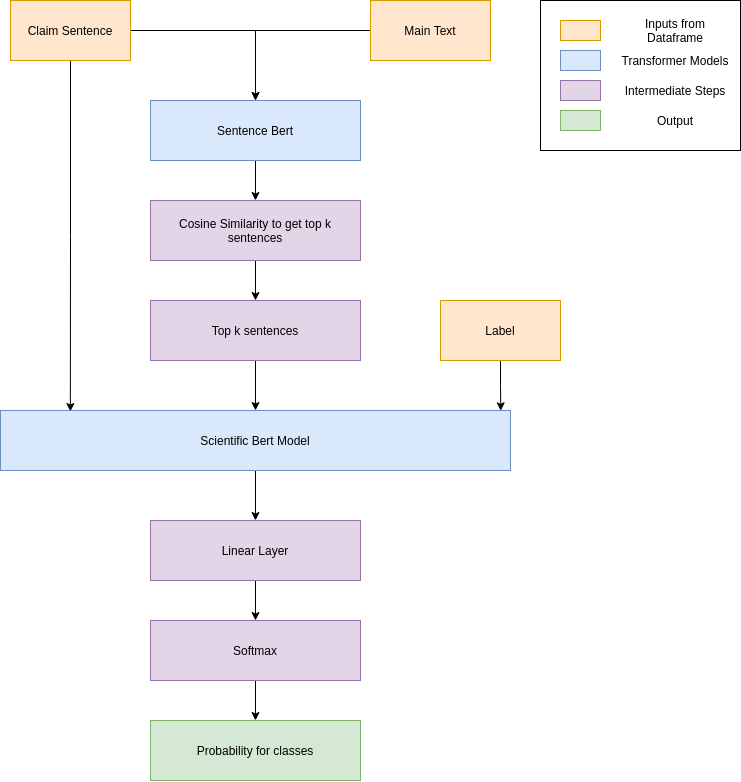

## Fetching topk sentences

In [10]:
def process_runner_function(df: DataFrame):
    '''
        A function to run all the sub functions for preprocessing. 
        - manual_config: 
            @param: df, A dataframe on which the processing has to be applied
        - Result:
            - Df with updated columns
    '''
    print('Splitting into sentences')
    df['main_text_sentences'] = df['main_text'].progress_apply(lambda x: split_into_sentences(x))
    
    print('Fetching topk sentences')
    df['top_k_sentences'] = df.progress_apply(lambda x: get_top_k_similar_sentences(x.claim, x.main_text_sentences, 5), axis=1)
    
    return df

In [11]:
train_df = process_runner_function(train_df)
test_df = process_runner_function(test_df)
val_df = process_runner_function(val_df)

Splitting into sentences


  0%|          | 0/9804 [00:00<?, ?it/s]

Fetching topk sentences


  0%|          | 0/9804 [00:00<?, ?it/s]

Splitting into sentences


  0%|          | 0/1233 [00:00<?, ?it/s]

Fetching topk sentences


  0%|          | 0/1233 [00:00<?, ?it/s]

Splitting into sentences


  0%|          | 0/1214 [00:00<?, ?it/s]

Fetching topk sentences


  0%|          | 0/1214 [00:00<?, ?it/s]

In [13]:
train_df['top_k_sentences_joined'] = train_df['top_k_sentences'].apply(lambda x: ''.join( x))
val_df['top_k_sentences_joined'] = val_df['top_k_sentences'].apply(lambda x: ''.join(x))
test_df['top_k_sentences_joined'] = test_df['top_k_sentences'].apply(lambda x: ''.join(x))

#### How many tokens will be needed? 

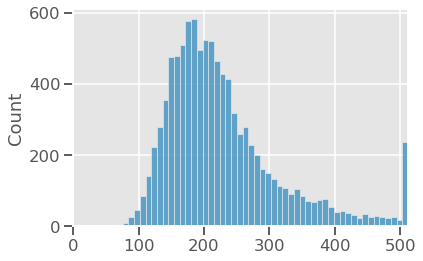

In [14]:
token_counts = []

tokenizer =  AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
for _, row in train_df.iterrows():
    token_count = len(tokenizer.encode(
    row["claim"],
    row['top_k_sentences_joined'],
    max_length=512,
    truncation='longest_first'
  ))
    token_counts.append(token_count)
    
sns.histplot(token_counts)
plt.xlim([0, 512]);

We can keep the token count to be 512, as it seems most of the examples out of 9k fit under 512, while only 2-300 exceed. 

## Model Building
In this section, we have: 
- ### Config 
- ### DataLoader
- ### Model

### Details about the configuration: 

For the model, I have chosen Scibert. Taking the research paper for this dataset in mind and noticing how Scibert performed the best overall, I set out to recreating the results from the paper. 

With no code properly provided, I set out to creating their architecture. 

There are many approaches and perhaps a Siamese or dual architecture could have given better results, but keeping in mind that this was a preliminary approach, I have gone with the default method of concatenating both the top k sentences and claim into one. 

After having explained that, let me go through my decision choices for the following blocks of code. 

Since this task is mainly to check my code building skills, I have left the model classes inside the Jupyter notebook itself, so that it is easier to read and evaluate. 

---

Thought process behind each class: 

- #### Config
 - The reason for the variables set: 
      1. Seed: 42 is a personal favourite of mine while setting a random seed. 
      2. Epochs: To keep it simple and to save on training time, the epochs were kept at 2. 
      3. Max_seq_length: Since most of the concatenated tokens fall under 512, it was an acceptable approach to set it as 512. 
      4. Batch Sizes: These were the ones which could best fit on my GPU under one go, thus, that's why those numbers were chosen. 
      5. Optimizer: AdamW; Simple, Effective, Fast for our particular use case. 
      6. Dropout: 0.2 to begin with.
      7. Warmup: 0.1, allows us to linearly scale up the learning rate during those steps. Avoids early overfitting. 
      8. Scheduler: linear, to keep it easy to follow and for the learning rate to not be affected much
  
  
- #### Model: 
 - Reasons
   1. The vanilla linear layer has the architecture of: 768->128, 128->4 (number of classes) This could be changed to some other architecture to get better resutls. 
   2. Loss function: CrossEntropyLoss: Already has softmax built in, suited for multi class classification. The weights have been initialized so that the imbalance doesn't effect the results as much. 
   
  

In [15]:
# Defining classes with values

class Config:

    def __init__(self):
        super(Config, self).__init__()
        
        #model
        self.seed = 42
        self.model_name_or_path = 'allenai/scibert_scivocab_uncased'
        self.num_labels = 4
        #device
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        #tokenizer
        self.tokenizer_name = 'allenai/scibert_scivocab_uncased'
        self.max_seq_length = 512

         # train
        self.epochs = 2
        self.train_batch_size = 8
        self.eval_batch_size = 12
        #test
        self.test_batch_size = 12

        # optimizer
        self.optimizer_type = 'AdamW'
        self.learning_rate = 3e-5

        self.dropout = 0.2
        self.weight_decay = 0.001


        # scheduler
        self.decay_name = 'linear-warmup'
        self.warmup_ratio = 0.2

        # logging
        self.logging_steps = 10

     
        # evaluate
        self.output_dir = 'output'


class DatasetRetriever(Dataset):
    def __init__(self, features, mode='train'):
        super(DatasetRetriever, self).__init__()
        self.features = features
        self.mode = mode
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, item):
        feature = self.features[item]
        if self.mode == 'train':
            return {
                'input_ids':torch.tensor(feature['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(feature['attention_mask'], dtype=torch.long),
                'label':torch.tensor(feature['label'], dtype=torch.long),
        
            }
        else:
            return {
                'input_ids':torch.tensor(feature['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(feature['attention_mask'], dtype=torch.long),
                
            }



     
        
        
class Model(nn.Module):
    def __init__(self, modelname_or_path, config, manual_config):
        super(Model, self).__init__()
        self.config = config
        self.scibert = AutoModel.from_pretrained(modelname_or_path, config=config)
        
        self.classifier = nn.Sequential(
            nn.Dropout(manual_config.dropout),
            nn.Linear(config.hidden_size, 128),
            nn.Linear(128, manual_config.num_labels)
            
        )

        
    def forward(
        self, 
        input_ids, 
        attention_mask=None, 
        token_type_ids=None
    ):
        outputs = self.scibert(
            input_ids= input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
        
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)
        
    
        return logits

In [16]:
# Functions to load the dataloader and create the model based on the config in the previous class


def make_loader(
    manual_config, tokenizer, train=None, val=None, test=None
    
):
    '''
        This function is used to create the data loader. The idea for the dataloader is a concatenation of claim
        and evidence sentences for this particualr approach. 
        
        Arguments:
        - @param: manual_config, dictionary, the features configured in the Config class. 
        - @param: tokenizer: The tokenizer loaded from the make_model function for splitting sentences into words. 
        - @param: train: dataframe: Train dataframe
        - @param: val: dataframe: Val dataframe
        - @param: test: dataframe: Test dataframe
        
        Returns:
            - Train/Test/Val dataloader. 
    
    
    '''
    
    if train is not None and val is not None:
        train_set, valid_set = train, val

        train_features, valid_features = [[] for _ in range(2)]
        print("Preparing train features")
        for i, row in tqdm(train_set.iterrows()):
            train_features += prepare_train_features(manual_config, row, tokenizer)

        print("Preparing validation features")
        for i, row in tqdm(valid_set.iterrows()):
            valid_features += prepare_train_features(manual_config, row, tokenizer)
            
        train_dataset = DatasetRetriever(train_features)
        valid_dataset = DatasetRetriever(valid_features)
    
        print(f"Num examples Train= {len(train_dataset)}, Num examples Valid={len(valid_dataset)}")

        train_sampler = RandomSampler(train_dataset)
        valid_sampler = SequentialSampler(valid_dataset)
        
        train_dataloader = DataLoader(
        train_dataset,
        batch_size=manual_config.train_batch_size,
        sampler=train_sampler,
        pin_memory=True,
        drop_last=False 
        )

        valid_dataloader = DataLoader(
            valid_dataset,
            batch_size=manual_config.eval_batch_size, 
            sampler=valid_sampler,
            pin_memory=True, 
            drop_last=False
        )
        
        
        
        return train_dataloader, valid_dataloader
        
    if test is not None:
        test_set = test
        test_features = []
        print("Preparing Test features")
        for i, row in tqdm(test_set.iterrows()):
            test_features += prepare_train_features(manual_config, row, tokenizer)
        test_dataset = DatasetRetriever(test_features)
        print(f'Num examples Test={len(test_dataset)}')

   
        test_sampler = SequentialSampler(test_dataset)

   
        test_dataloader = DataLoader(
        test_dataset,
        batch_size=manual_config.test_batch_size, 
        sampler=test_sampler,
        pin_memory=True, 
        drop_last=False
        )


        return test_dataloader



def make_model(manual_config):
    '''
        This function is used to create: The model configuration (base) and the tokenizer needed for the model
        training
        
        Args: 
        - @param: manual_config: dictionary, all information from the Config class
        
        Returns: 
        - Model_Config
        - Tokenizer
        - Loaded Model
    '''
    
    config = AutoConfig.from_pretrained(manual_config.model_name_or_path)
    tokenizer = AutoTokenizer.from_pretrained(manual_config.tokenizer_name)
    model = Model(manual_config.model_name_or_path, config=config, manual_config = manual_config)
    return config, tokenizer, model



### Creating Classes for Train and Evaluate

In [17]:
class Trainer:
    def __init__(
        self, model, tokenizer, 
        optimizer, scheduler, config
    ):
        self.model = model
        self.tokenizer = tokenizer
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.class_weights = class_weights
        self.criterion = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')

    def train(
        self, manual_config, 
        train_dataloader, 
        epoch, result_dict
    ):
        count = 0
        losses = AverageMeter()
        
        self.model.zero_grad()
        self.model.train()
        
        fix_all_seeds(manual_config.seed)
        
        for batch_idx, batch_data in enumerate(train_dataloader):
            input_ids, attention_mask, target = \
                batch_data['input_ids'], batch_data['attention_mask'], \
                    batch_data['label']
            
            input_ids, attention_mask, target = input_ids.cuda(), attention_mask.cuda(), target.cuda()

            logits = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            
            
            
            self.optimizer.zero_grad()

            #calculate losss
           
            loss = self.criterion(logits, target)
            
            #backward pass
            loss.backward()

            count += input_ids.size(0)
            losses.update(loss.item(), input_ids.size(0))


           
            self.optimizer.step()
            self.scheduler.step()
            
            
            #Print loss when batches complete

            if (batch_idx+1)==len(train_dataloader):
                _s = str(len(str(len(train_dataloader.sampler))))
                ret = [
                    ('Epoch: {:0>2} [{: >' + _s + '}/{} ({: >3.0f}%)]').format(epoch, count, len(train_dataloader.sampler), 100 * count / len(train_dataloader.sampler)),
                    'Train Loss: {: >4.5f}'.format(losses.avg),
                ]
                print(', '.join(ret))

        result_dict['train_loss'].append(losses.avg)
        return result_dict

In [18]:
class Evaluator:
    def __init__(self, model, config):
        self.model = model
        self.criterion = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')

    
    def save(self, result, output_dir):
        with open(f'{output_dir}/result_dict.json', 'w') as f:
            f.write(json.dumps(result, sort_keys=True, indent=4, ensure_ascii=False))

    def evaluate(self, valid_dataloader, epoch, result_dict):
        #Initialize base losses
        losses = AverageMeter()
        for batch_idx, batch_data in enumerate(valid_dataloader):
            self.model = self.model.eval()
            
            input_ids, attention_mask, targets = \
                batch_data['input_ids'], batch_data['attention_mask'], \
                    batch_data['label']
            
            input_ids, attention_mask, targets = \
                input_ids.cuda(), attention_mask.cuda(), targets.cuda()
            
            # We use torch.no_grad() to skip all gradient calc over the weights for the evaluation process
            with torch.no_grad():            
                logits = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                )
                
                loss = self.criterion(logits, targets)
                losses.update(loss.item(), input_ids.size(0))
                
        print('----Validation Results Summary----')
        print('Epoch: [{}] Valid Loss: {: >4.5f}'.format(epoch, losses.avg))
        result_dict['val_loss'].append(losses.avg)        
        return result_dict

In [19]:
def init_training(manual_config, train_df, val_df):
    fix_all_seeds(manual_config.seed)
    
    if not os.path.exists(manual_config.output_dir):
        os.makedirs(manual_config.output_dir)
    
    # model
  
    model_config, tokenizer, model = make_model(manual_config)
    if torch.cuda.device_count() >= 1:
        print('Model pushed to {} GPU(s), type {}.'.format(
            torch.cuda.device_count(), 
            torch.cuda.get_device_name(0))
        )
        model = model.cuda() 
    else:
        raise ValueError('CPU training is not supported')
    
    # data loaders
    train_dataloader, valid_dataloader = make_loader(manual_config,tokenizer,  train=train_df, val=val_df )

    # optimizer setup
    optimizer = make_optimizer(manual_config, model)

    # scheduler
    num_training_steps = math.ceil(len(train_dataloader)) * manual_config.epochs
    if manual_config.warmup_ratio > 0:
        num_warmup_steps = int(manual_config.warmup_ratio * num_training_steps)
    else:
        num_warmup_steps = 0
    print(f"Total Training Steps: {num_training_steps}, Total Warmup Steps: {num_warmup_steps}")
    scheduler = make_scheduler(manual_config, optimizer, num_warmup_steps, num_training_steps)

  
    
    result_dict = {
        'epoch':[], 
        'train_loss': [], 
        'val_loss' : [], 
        'best_val_loss': np.inf
    }

    return (
        model, model_config, tokenizer, optimizer, scheduler, 
        train_dataloader, valid_dataloader, result_dict
    )

In [20]:
def run(train_df, val_df):
    manual_config = Config()
    model, model_config, tokenizer, optimizer, scheduler, train_dataloader, \
        valid_dataloader, result_dict = init_training(manual_config, train_df, val_df)
    
    trainer = Trainer(model, tokenizer, optimizer, scheduler, manual_config)
    evaluator = Evaluator(model, manual_config)

    train_time_list = []
    valid_time_list = []

    for epoch in range(manual_config.epochs):
        result_dict['epoch'].append(epoch)

        # Train and calc the time
        torch.cuda.synchronize()
        tic1 = time.time()
        result_dict = trainer.train(
            manual_config, train_dataloader, 
            epoch, result_dict
        )
        torch.cuda.synchronize()
        tic2 = time.time() 
        train_time_list.append(tic2 - tic1)
        
        # Evaluate and clac the time
        torch.cuda.synchronize()
        tic3 = time.time()
        result_dict = evaluator.evaluate(
            valid_dataloader, epoch, result_dict
        )
        torch.cuda.synchronize()
        tic4 = time.time() 
        valid_time_list.append(tic4 - tic3)
            
        # Save best output
        output_dir = manual_config.output_dir
        if result_dict['val_loss'][-1] < result_dict['best_val_loss']:
            print("{} Epoch, Best epoch was updated! Valid Loss: {: >4.5f}".format(epoch, result_dict['val_loss'][-1]))
            result_dict["best_val_loss"] = result_dict['val_loss'][-1]        
            
            os.makedirs(output_dir, exist_ok=True)
            torch.save(model.state_dict(), f"{output_dir}/pytorch_model.bin")
            model_config.save_pretrained(output_dir)
            tokenizer.save_pretrained(output_dir)
            print(f"Saving model checkpoint to {output_dir}.")
            
     

    evaluator.save(result_dict, output_dir)
    
    print(f"Total Training Time: {np.sum(train_time_list)}secs, Average Training Time per Epoch: {np.mean(train_time_list)}secs.")
    print(f"Total Validation Time: {np.sum(valid_time_list)}secs, Average Validation Time per Epoch: {np.mean(valid_time_list)}secs.")
    
    
    #Free up memory from GPU to allow to re-train faster
    torch.cuda.empty_cache()
    del trainer, evaluator
    del optimizer, scheduler
    del train_dataloader, valid_dataloader, result_dict
    gc.collect()
    
    model, model_config, tokenizer =  model, model_config, tokenizer
    
    return model, model_config, tokenizer

# Training the model

In [21]:
model, model_config, tokenizer = run(train_df, val_df)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type GeForce RTX 3060.
Preparing train features


0it [00:00, ?it/s]

Preparing validation features


0it [00:00, ?it/s]

Num examples Train= 9804, Num examples Valid=1214
Total Training Steps: 2452, Total Warmup Steps: 490
Epoch: 00 [9804/9804 (100%)], Train Loss: 1.06362
----Validation Results Summary----
Epoch: [0] Valid Loss: 0.90552
0 Epoch, Best epoch was updated! Valid Loss: 0.90552
Saving model checkpoint to output.
Epoch: 01 [9804/9804 (100%)], Train Loss: 0.63460
----Validation Results Summary----
Epoch: [1] Valid Loss: 0.85210
1 Epoch, Best epoch was updated! Valid Loss: 0.85210
Saving model checkpoint to output.
Total Training Time: 917.1019823551178secs, Average Training Time per Epoch: 458.5509911775589secs.
Total Validation Time: 35.69749426841736secs, Average Validation Time per Epoch: 17.84874713420868secs.


# Performance on test dataset

In [22]:
manual_config = Config()

In [23]:
def predict_on_test(model):
    test_dataloader = make_loader(manual_config, tokenizer,  test=test_df)
    # Creating true values:
    test_true = []
    for index, item in enumerate(test_dataloader):
        test_true.extend(item['label'].cpu().numpy())
        
    test_loss = 0
    test_pred = []
    model.eval()
    for step, batch in enumerate(test_dataloader):
        b_input_ids = batch['input_ids'].cuda()
        b_attention_mask = batch['attention_mask'].cuda()

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
            logits = torch.argmax(logits, dim=1)
            logits = logits.cpu().numpy()
            test_pred.extend(logits)

    test_pred = np.array(test_pred)
   
    
    return test_pred, test_true



In [24]:
test_pred, test_true = predict_on_test(model)

Preparing Test features


0it [00:00, ?it/s]

Num examples Test=1233


In [25]:
print(classification_report(test_pred, test_true))

              precision    recall  f1-score   support

           0       0.66      0.65      0.66       399
           1       0.45      0.35      0.40       259
           2       0.74      0.90      0.81       491
           3       0.60      0.32      0.42        84

    accuracy                           0.66      1233
   macro avg       0.61      0.55      0.57      1233
weighted avg       0.64      0.66      0.65      1233



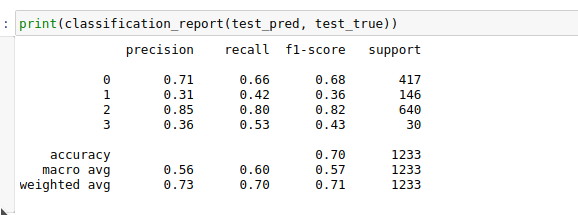

# Result Discussion

We have built a basic model for the classification of health claims. The architecture followed was the same as from the research paper regarding the current dataset. 

From the result we can observe that the macro F1 score doesn't really equate to the results provided in the Paper. With the same model and a somewhat similar architecture, we can see:

1. Paper Macro F1: 70
2. Our Macro F1: 57


This could have a few reasons: 
- The linear layer could be underwhelmed and seems to be overfitting on the training data over multiple epochs. It could have more dropouts to prevent that.  




# Future work to improve performance. 

For future improvements, there could be multiple other tricks that could be implied to make it perform better. 
1. Create a siamese architecture / Dual SciBert to see if that performs better when the tokens fit in perfectly. 
2. Create a more compled DNN for the model to perform better with the train/unseen data. 
3. Train via k-fold for it to scale up better. 
4. Enhance the dataset with other fact-checking health datasets such as pubmed. 
5. Perform hyperparameter tuning to get the best params for training. 
6. Add more parameters for the optimizers. 
